# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

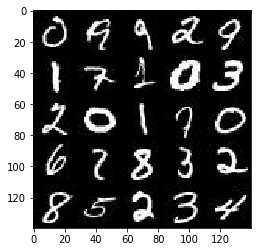

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

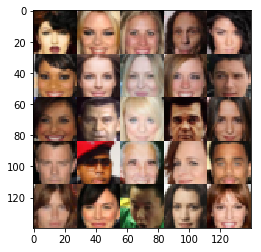

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    read_input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_img = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32,())
    return (read_input_img, z_img, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # input image is 28x28x3
    with(tf.variable_scope('discriminator', reuse = reuse)):
        # input image is 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        dropout1 = tf.nn.dropout(relu1,0.7)
        
        # image is 14x14x64
        layer2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * layer2_bn, layer2_bn)
        dropout2 = tf.nn.dropout(relu2,0.7)
        
        # image is 7x7x128
        layer3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        layer3_bn = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * layer3_bn, layer3_bn)
        dropout3 = tf.nn.dropout(relu3,0.7)
        
        # image is 4x4x256          
        # flatten data
        #flatten = tf.reshape(dropout3, (-1, 4*4*256))
        # try new approach using tf.layers.flatten()
        flatten = tf.contrib.layers.flatten(dropout3)
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with(tf.variable_scope('generator', reuse = not is_train)):
        # random vector of dimensions z
        layer1_dense = tf.layers.dense(z, 7*7*512)
        # reshape so we can start to convolution
        image_ = tf.reshape(layer1_dense, (-1, 7, 7, 512))
        layer1_bn = tf.layers.batch_normalization(image_, training=is_train)
        layer1_lrl = tf.maximum(alpha * layer1_bn, layer1_bn)
        layer1_dropout = tf.nn.dropout(layer1_lrl, 0.7)
        
        # image is 7x7x512
        layer2_conv2d_t = tf.layers.conv2d_transpose(layer1_dropout, 256, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2_conv2d_t, training=is_train)
        layer2_lrl = tf.maximum(alpha * layer2_bn, layer2_bn)
        layer2_dropout = tf.nn.dropout(layer2_lrl, 0.7)
        
        # image is 14x14x256
        layer3_conv2d_t = tf.layers.conv2d_transpose(layer2_dropout, 128, 5, strides=2, padding='same')
        layer3_bn = tf.layers.batch_normalization(layer3_conv2d_t, training=is_train)
        layer3_lrl = tf.maximum(alpha * layer3_bn, layer3_bn)
        layer3_dropout = tf.nn.dropout(layer3_lrl, 0.7)
        
        # image is 28x28x128
        logits = tf.layers.conv2d_transpose(layer3_dropout, out_channel_dim, 5, strides=1, padding='same')
        
        # image is 28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    real_label_smoothing = tf.ones_like(d_logits_real) * (1 - 0.1)    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels = real_label_smoothing))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels = tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels = tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with(tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS))):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, z_data, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    
    d_loss, g_loss = model_loss(images, z_data, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_images_every_batch = 200
    print_loss_every_batch = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                #as batch_images are between [-0.5,0.5] and we are using tanh in the generator [-1,1],
                #we need to reescale batch_images
                batch_images = batch_images * 2 
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict = {images: batch_images, z_data : batch_z})
                _ = sess.run(g_opt, feed_dict = {images: batch_images, z_data : batch_z})
                _ = sess.run(g_opt, feed_dict = {images: batch_images, z_data : batch_z})
                
                if(step % print_loss_every_batch) == 0:
                    train_loss_d = d_loss.eval({images : batch_images, z_data : batch_z})
                    train_loss_g = g_loss.eval({images : batch_images, z_data : batch_z})
                    print('Epoch: ' +str(epoch_i)+ ' - Discriminator Loss: ' + str(train_loss_d) + ' ..... Generator Loss: ' + str(train_loss_g))
                    
                
                if(step % print_images_every_batch) == 0:
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 - Discriminator Loss: 1.45483 ..... Generator Loss: 0.843041
Epoch: 0 - Discriminator Loss: 1.51839 ..... Generator Loss: 0.739164
Epoch: 0 - Discriminator Loss: 1.51541 ..... Generator Loss: 0.858848
Epoch: 0 - Discriminator Loss: 1.4551 ..... Generator Loss: 1.12454
Epoch: 0 - Discriminator Loss: 1.4962 ..... Generator Loss: 0.809099
Epoch: 0 - Discriminator Loss: 1.51004 ..... Generator Loss: 0.991804
Epoch: 0 - Discriminator Loss: 1.33987 ..... Generator Loss: 0.904906
Epoch: 0 - Discriminator Loss: 1.48164 ..... Generator Loss: 1.19781


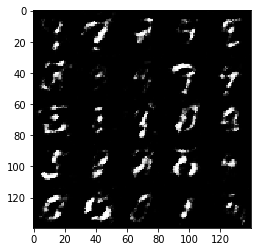

Epoch: 0 - Discriminator Loss: 1.27934 ..... Generator Loss: 1.3154
Epoch: 0 - Discriminator Loss: 1.26599 ..... Generator Loss: 1.11451
Epoch: 0 - Discriminator Loss: 1.24054 ..... Generator Loss: 1.05536
Epoch: 0 - Discriminator Loss: 1.54589 ..... Generator Loss: 1.34735
Epoch: 0 - Discriminator Loss: 1.38431 ..... Generator Loss: 1.0957
Epoch: 0 - Discriminator Loss: 1.28682 ..... Generator Loss: 0.925344
Epoch: 0 - Discriminator Loss: 1.37546 ..... Generator Loss: 1.08352
Epoch: 0 - Discriminator Loss: 1.39515 ..... Generator Loss: 0.740123


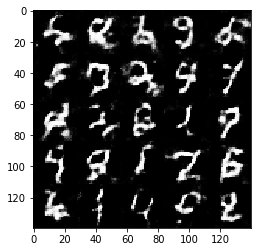

Epoch: 0 - Discriminator Loss: 1.40537 ..... Generator Loss: 0.800162
Epoch: 0 - Discriminator Loss: 1.45903 ..... Generator Loss: 0.72402
Epoch: 0 - Discriminator Loss: 1.27128 ..... Generator Loss: 1.20905
Epoch: 0 - Discriminator Loss: 1.32719 ..... Generator Loss: 0.808716
Epoch: 0 - Discriminator Loss: 1.34852 ..... Generator Loss: 1.30479
Epoch: 0 - Discriminator Loss: 1.32214 ..... Generator Loss: 0.773653
Epoch: 0 - Discriminator Loss: 1.3524 ..... Generator Loss: 1.19351
Epoch: 0 - Discriminator Loss: 1.30322 ..... Generator Loss: 1.25722


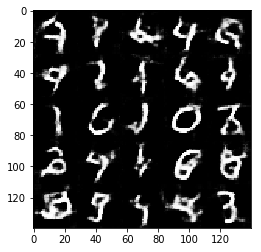

Epoch: 0 - Discriminator Loss: 1.34478 ..... Generator Loss: 0.876999
Epoch: 0 - Discriminator Loss: 1.39426 ..... Generator Loss: 0.910452
Epoch: 0 - Discriminator Loss: 1.37746 ..... Generator Loss: 1.07305
Epoch: 0 - Discriminator Loss: 1.33105 ..... Generator Loss: 0.821248
Epoch: 0 - Discriminator Loss: 1.16468 ..... Generator Loss: 0.988068
Epoch: 0 - Discriminator Loss: 1.28183 ..... Generator Loss: 1.042
Epoch: 0 - Discriminator Loss: 1.43926 ..... Generator Loss: 0.742244
Epoch: 0 - Discriminator Loss: 1.26699 ..... Generator Loss: 1.07015


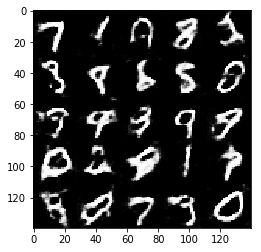

Epoch: 0 - Discriminator Loss: 1.25707 ..... Generator Loss: 0.836654
Epoch: 0 - Discriminator Loss: 1.27087 ..... Generator Loss: 0.904967
Epoch: 0 - Discriminator Loss: 1.3227 ..... Generator Loss: 0.81158
Epoch: 0 - Discriminator Loss: 1.3489 ..... Generator Loss: 0.792748
Epoch: 0 - Discriminator Loss: 1.26481 ..... Generator Loss: 1.01739
Epoch: 1 - Discriminator Loss: 1.37328 ..... Generator Loss: 0.805099
Epoch: 1 - Discriminator Loss: 1.23663 ..... Generator Loss: 0.986991
Epoch: 1 - Discriminator Loss: 1.26162 ..... Generator Loss: 0.890157


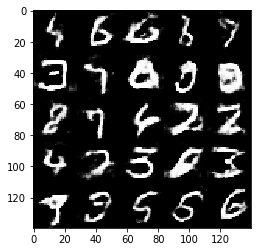

Epoch: 1 - Discriminator Loss: 1.29203 ..... Generator Loss: 1.15838
Epoch: 1 - Discriminator Loss: 1.32328 ..... Generator Loss: 0.783267
Epoch: 1 - Discriminator Loss: 1.31303 ..... Generator Loss: 0.938015
Epoch: 1 - Discriminator Loss: 1.27908 ..... Generator Loss: 1.00054
Epoch: 1 - Discriminator Loss: 1.37526 ..... Generator Loss: 0.75085
Epoch: 1 - Discriminator Loss: 1.22102 ..... Generator Loss: 1.18475
Epoch: 1 - Discriminator Loss: 1.36418 ..... Generator Loss: 0.946176
Epoch: 1 - Discriminator Loss: 1.33254 ..... Generator Loss: 0.788826


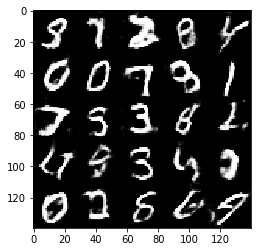

Epoch: 1 - Discriminator Loss: 1.3643 ..... Generator Loss: 0.994589
Epoch: 1 - Discriminator Loss: 1.26175 ..... Generator Loss: 0.936416
Epoch: 1 - Discriminator Loss: 1.35245 ..... Generator Loss: 0.792217
Epoch: 1 - Discriminator Loss: 1.20769 ..... Generator Loss: 1.0142
Epoch: 1 - Discriminator Loss: 1.1936 ..... Generator Loss: 0.974731
Epoch: 1 - Discriminator Loss: 1.27339 ..... Generator Loss: 0.927028
Epoch: 1 - Discriminator Loss: 1.38354 ..... Generator Loss: 0.83722
Epoch: 1 - Discriminator Loss: 1.32008 ..... Generator Loss: 0.936427


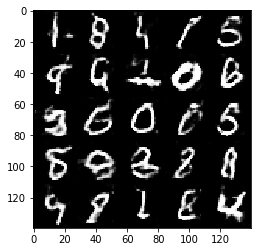

Epoch: 1 - Discriminator Loss: 1.25828 ..... Generator Loss: 0.882794
Epoch: 1 - Discriminator Loss: 1.46931 ..... Generator Loss: 0.802293
Epoch: 1 - Discriminator Loss: 1.16787 ..... Generator Loss: 0.836185
Epoch: 1 - Discriminator Loss: 1.35798 ..... Generator Loss: 0.723496
Epoch: 1 - Discriminator Loss: 1.31166 ..... Generator Loss: 0.983977
Epoch: 1 - Discriminator Loss: 1.30494 ..... Generator Loss: 0.774303
Epoch: 1 - Discriminator Loss: 1.26497 ..... Generator Loss: 0.95496
Epoch: 1 - Discriminator Loss: 1.16955 ..... Generator Loss: 1.01953


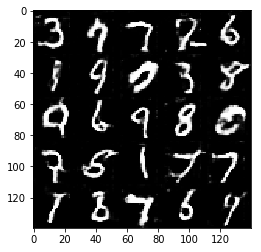

Epoch: 1 - Discriminator Loss: 1.45568 ..... Generator Loss: 0.963819
Epoch: 1 - Discriminator Loss: 1.17857 ..... Generator Loss: 1.00735
Epoch: 1 - Discriminator Loss: 1.24771 ..... Generator Loss: 1.16369
Epoch: 1 - Discriminator Loss: 1.21551 ..... Generator Loss: 0.902638
Epoch: 1 - Discriminator Loss: 1.20255 ..... Generator Loss: 1.03778
Epoch: 1 - Discriminator Loss: 1.22312 ..... Generator Loss: 1.08079
Epoch: 1 - Discriminator Loss: 1.35287 ..... Generator Loss: 0.816863
Epoch: 1 - Discriminator Loss: 1.31878 ..... Generator Loss: 0.790431


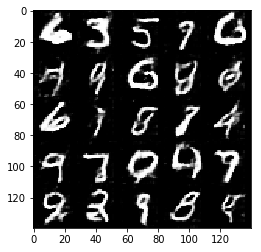

Epoch: 1 - Discriminator Loss: 1.33203 ..... Generator Loss: 0.916396
Epoch: 1 - Discriminator Loss: 1.3476 ..... Generator Loss: 1.10935


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 - Discriminator Loss: 1.10786 ..... Generator Loss: 2.64046
Epoch: 0 - Discriminator Loss: 0.80891 ..... Generator Loss: 2.76797
Epoch: 0 - Discriminator Loss: 0.648273 ..... Generator Loss: 2.17825
Epoch: 0 - Discriminator Loss: 0.630644 ..... Generator Loss: 2.60592
Epoch: 0 - Discriminator Loss: 0.764313 ..... Generator Loss: 2.61926
Epoch: 0 - Discriminator Loss: 0.804368 ..... Generator Loss: 1.81329
Epoch: 0 - Discriminator Loss: 0.870157 ..... Generator Loss: 2.88665
Epoch: 0 - Discriminator Loss: 1.04751 ..... Generator Loss: 1.01925


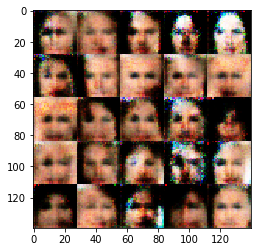

Epoch: 0 - Discriminator Loss: 1.14316 ..... Generator Loss: 1.25356
Epoch: 0 - Discriminator Loss: 1.44731 ..... Generator Loss: 1.64197
Epoch: 0 - Discriminator Loss: 0.873333 ..... Generator Loss: 1.83675
Epoch: 0 - Discriminator Loss: 1.27638 ..... Generator Loss: 1.12552
Epoch: 0 - Discriminator Loss: 1.24286 ..... Generator Loss: 1.08597
Epoch: 0 - Discriminator Loss: 1.34081 ..... Generator Loss: 1.11953
Epoch: 0 - Discriminator Loss: 1.33512 ..... Generator Loss: 0.848835
Epoch: 0 - Discriminator Loss: 1.54505 ..... Generator Loss: 1.25603


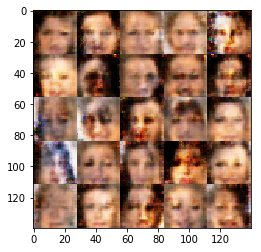

Epoch: 0 - Discriminator Loss: 1.49396 ..... Generator Loss: 0.896694
Epoch: 0 - Discriminator Loss: 1.81978 ..... Generator Loss: 0.618915
Epoch: 0 - Discriminator Loss: 1.48228 ..... Generator Loss: 0.862406
Epoch: 0 - Discriminator Loss: 1.54717 ..... Generator Loss: 0.89229
Epoch: 0 - Discriminator Loss: 1.48534 ..... Generator Loss: 0.93406
Epoch: 0 - Discriminator Loss: 1.58222 ..... Generator Loss: 0.745009
Epoch: 0 - Discriminator Loss: 1.54945 ..... Generator Loss: 0.772541
Epoch: 0 - Discriminator Loss: 1.43618 ..... Generator Loss: 0.899352


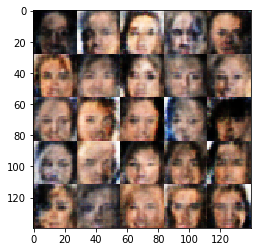

Epoch: 0 - Discriminator Loss: 1.42503 ..... Generator Loss: 0.823113
Epoch: 0 - Discriminator Loss: 1.38552 ..... Generator Loss: 0.83177
Epoch: 0 - Discriminator Loss: 1.44295 ..... Generator Loss: 0.937899
Epoch: 0 - Discriminator Loss: 1.5098 ..... Generator Loss: 0.780865
Epoch: 0 - Discriminator Loss: 1.55069 ..... Generator Loss: 0.840616
Epoch: 0 - Discriminator Loss: 1.53346 ..... Generator Loss: 0.865482
Epoch: 0 - Discriminator Loss: 1.52144 ..... Generator Loss: 0.748428
Epoch: 0 - Discriminator Loss: 1.3994 ..... Generator Loss: 0.927446


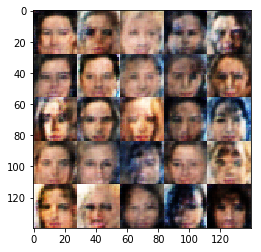

Epoch: 0 - Discriminator Loss: 1.43668 ..... Generator Loss: 0.827506
Epoch: 0 - Discriminator Loss: 1.47352 ..... Generator Loss: 0.83722
Epoch: 0 - Discriminator Loss: 1.42799 ..... Generator Loss: 0.882587
Epoch: 0 - Discriminator Loss: 1.39873 ..... Generator Loss: 0.823109
Epoch: 0 - Discriminator Loss: 1.39625 ..... Generator Loss: 0.875058
Epoch: 0 - Discriminator Loss: 1.50693 ..... Generator Loss: 0.822618
Epoch: 0 - Discriminator Loss: 1.25001 ..... Generator Loss: 0.955864
Epoch: 0 - Discriminator Loss: 1.31089 ..... Generator Loss: 0.908135


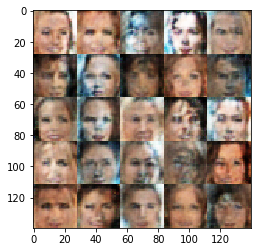

Epoch: 0 - Discriminator Loss: 1.44753 ..... Generator Loss: 0.944528
Epoch: 0 - Discriminator Loss: 1.38644 ..... Generator Loss: 0.866937
Epoch: 0 - Discriminator Loss: 1.4418 ..... Generator Loss: 0.891773
Epoch: 0 - Discriminator Loss: 1.38646 ..... Generator Loss: 0.869673
Epoch: 0 - Discriminator Loss: 1.44132 ..... Generator Loss: 0.74615
Epoch: 0 - Discriminator Loss: 1.35657 ..... Generator Loss: 0.874254
Epoch: 0 - Discriminator Loss: 1.31135 ..... Generator Loss: 0.987698
Epoch: 0 - Discriminator Loss: 1.4964 ..... Generator Loss: 0.772962


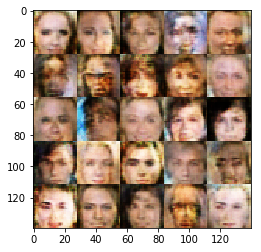

Epoch: 0 - Discriminator Loss: 1.42408 ..... Generator Loss: 0.802212
Epoch: 0 - Discriminator Loss: 1.43611 ..... Generator Loss: 0.860582
Epoch: 0 - Discriminator Loss: 1.44962 ..... Generator Loss: 0.845366
Epoch: 0 - Discriminator Loss: 1.46964 ..... Generator Loss: 0.710008
Epoch: 0 - Discriminator Loss: 1.47421 ..... Generator Loss: 0.743887
Epoch: 0 - Discriminator Loss: 1.35416 ..... Generator Loss: 0.775218
Epoch: 0 - Discriminator Loss: 1.40239 ..... Generator Loss: 0.719005
Epoch: 0 - Discriminator Loss: 1.46671 ..... Generator Loss: 0.937111


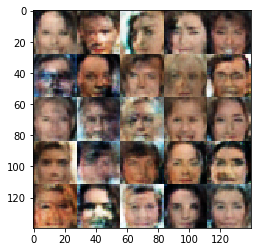

Epoch: 0 - Discriminator Loss: 1.36249 ..... Generator Loss: 0.922767
Epoch: 0 - Discriminator Loss: 1.38811 ..... Generator Loss: 0.826087
Epoch: 0 - Discriminator Loss: 1.43709 ..... Generator Loss: 0.887872
Epoch: 0 - Discriminator Loss: 1.4683 ..... Generator Loss: 0.719174
Epoch: 0 - Discriminator Loss: 1.48192 ..... Generator Loss: 0.81431
Epoch: 0 - Discriminator Loss: 1.45948 ..... Generator Loss: 0.723461
Epoch: 0 - Discriminator Loss: 1.39603 ..... Generator Loss: 0.801229
Epoch: 0 - Discriminator Loss: 1.44892 ..... Generator Loss: 0.665847


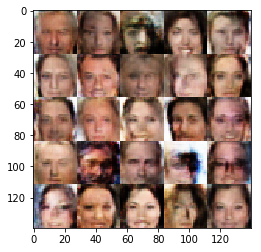

Epoch: 0 - Discriminator Loss: 1.42728 ..... Generator Loss: 0.786757
Epoch: 0 - Discriminator Loss: 1.40645 ..... Generator Loss: 0.845335
Epoch: 0 - Discriminator Loss: 1.38607 ..... Generator Loss: 0.738492
Epoch: 0 - Discriminator Loss: 1.43446 ..... Generator Loss: 0.718696
Epoch: 0 - Discriminator Loss: 1.42367 ..... Generator Loss: 0.802775
Epoch: 0 - Discriminator Loss: 1.45362 ..... Generator Loss: 0.85639
Epoch: 0 - Discriminator Loss: 1.38824 ..... Generator Loss: 0.905125
Epoch: 0 - Discriminator Loss: 1.47824 ..... Generator Loss: 0.763087


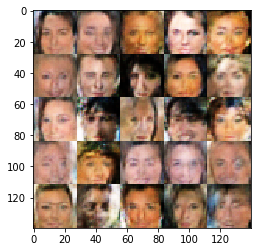

Epoch: 0 - Discriminator Loss: 1.43149 ..... Generator Loss: 0.713951
Epoch: 0 - Discriminator Loss: 1.44706 ..... Generator Loss: 0.784838
Epoch: 0 - Discriminator Loss: 1.41975 ..... Generator Loss: 0.864692
Epoch: 0 - Discriminator Loss: 1.32956 ..... Generator Loss: 0.981257
Epoch: 0 - Discriminator Loss: 1.42574 ..... Generator Loss: 0.841277
Epoch: 0 - Discriminator Loss: 1.43193 ..... Generator Loss: 0.693714
Epoch: 0 - Discriminator Loss: 1.39021 ..... Generator Loss: 0.741673
Epoch: 0 - Discriminator Loss: 1.41645 ..... Generator Loss: 0.804105


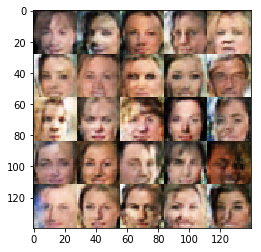

Epoch: 0 - Discriminator Loss: 1.40631 ..... Generator Loss: 0.777501
Epoch: 0 - Discriminator Loss: 1.42682 ..... Generator Loss: 0.861389
Epoch: 0 - Discriminator Loss: 1.39037 ..... Generator Loss: 0.803087
Epoch: 0 - Discriminator Loss: 1.39003 ..... Generator Loss: 0.756085
Epoch: 0 - Discriminator Loss: 1.39006 ..... Generator Loss: 0.805714
Epoch: 0 - Discriminator Loss: 1.43087 ..... Generator Loss: 0.790997
Epoch: 0 - Discriminator Loss: 1.42434 ..... Generator Loss: 0.777108
Epoch: 0 - Discriminator Loss: 1.38398 ..... Generator Loss: 0.754733


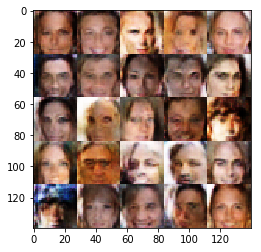

Epoch: 0 - Discriminator Loss: 1.37896 ..... Generator Loss: 0.891317
Epoch: 0 - Discriminator Loss: 1.39951 ..... Generator Loss: 0.79027
Epoch: 0 - Discriminator Loss: 1.39351 ..... Generator Loss: 0.775966
Epoch: 0 - Discriminator Loss: 1.41974 ..... Generator Loss: 0.701758
Epoch: 0 - Discriminator Loss: 1.37716 ..... Generator Loss: 0.779999
Epoch: 0 - Discriminator Loss: 1.41268 ..... Generator Loss: 0.778367
Epoch: 0 - Discriminator Loss: 1.48388 ..... Generator Loss: 0.824557
Epoch: 0 - Discriminator Loss: 1.38475 ..... Generator Loss: 0.674501


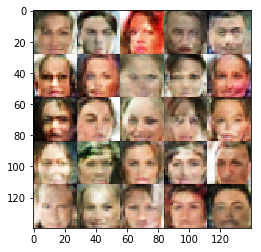

Epoch: 0 - Discriminator Loss: 1.37483 ..... Generator Loss: 0.810993
Epoch: 0 - Discriminator Loss: 1.49602 ..... Generator Loss: 0.741552
Epoch: 0 - Discriminator Loss: 1.40986 ..... Generator Loss: 0.796471
Epoch: 0 - Discriminator Loss: 1.37001 ..... Generator Loss: 0.834208
Epoch: 0 - Discriminator Loss: 1.47795 ..... Generator Loss: 0.791573
Epoch: 0 - Discriminator Loss: 1.37696 ..... Generator Loss: 0.796164
Epoch: 0 - Discriminator Loss: 1.34884 ..... Generator Loss: 0.861645
Epoch: 0 - Discriminator Loss: 1.38042 ..... Generator Loss: 0.705529


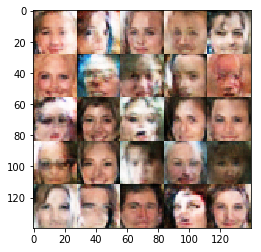

Epoch: 0 - Discriminator Loss: 1.39249 ..... Generator Loss: 0.808847
Epoch: 0 - Discriminator Loss: 1.3955 ..... Generator Loss: 0.815995
Epoch: 0 - Discriminator Loss: 1.35223 ..... Generator Loss: 0.803877
Epoch: 0 - Discriminator Loss: 1.41718 ..... Generator Loss: 0.723445
Epoch: 0 - Discriminator Loss: 1.45874 ..... Generator Loss: 0.758254
Epoch: 0 - Discriminator Loss: 1.48647 ..... Generator Loss: 0.708308
Epoch: 0 - Discriminator Loss: 1.37043 ..... Generator Loss: 0.839869
Epoch: 0 - Discriminator Loss: 1.37999 ..... Generator Loss: 0.842991


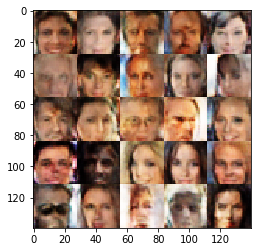

Epoch: 0 - Discriminator Loss: 1.34124 ..... Generator Loss: 0.844201
Epoch: 0 - Discriminator Loss: 1.38349 ..... Generator Loss: 0.758199
Epoch: 0 - Discriminator Loss: 1.37186 ..... Generator Loss: 0.837695
Epoch: 0 - Discriminator Loss: 1.39211 ..... Generator Loss: 0.715463
Epoch: 0 - Discriminator Loss: 1.46276 ..... Generator Loss: 0.724785
Epoch: 0 - Discriminator Loss: 1.38737 ..... Generator Loss: 0.704845
Epoch: 0 - Discriminator Loss: 1.41142 ..... Generator Loss: 0.836626
Epoch: 0 - Discriminator Loss: 1.36741 ..... Generator Loss: 0.802155


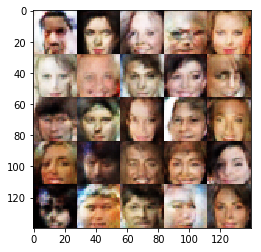

Epoch: 0 - Discriminator Loss: 1.43511 ..... Generator Loss: 0.720101
Epoch: 0 - Discriminator Loss: 1.50635 ..... Generator Loss: 0.763374
Epoch: 0 - Discriminator Loss: 1.40896 ..... Generator Loss: 0.740419
Epoch: 0 - Discriminator Loss: 1.39077 ..... Generator Loss: 0.787466
Epoch: 0 - Discriminator Loss: 1.4079 ..... Generator Loss: 0.814479
Epoch: 0 - Discriminator Loss: 1.38143 ..... Generator Loss: 0.848455


In [16]:
#batch_size = 32
#z_dim = 150
#learning_rate = 0.0002
#beta1 = 0.5

batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.